<a href="https://colab.research.google.com/github/nicholasdcrotty/CDVMBG_BRM_CNNOculomotorAnalysis/blob/main/analysisForReplication/CDVMBG_BRM_CNNBasedAnalysis_ForReplication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Using CNNs to analyze oculomotor timecourse data - Replicating observed results from Crotty, Doyle, Volkova, Massa, Benson, & Grubb (in prep)


Before running this code, make sure to select a fast runtime (either your own local runtime or one provided by Colab), as the model fitting procedure and SHAP analysis takes quite some time on the CPU alone. **NOTE: Due to the inherent stochasticty in the neural network fitting process, the resulting classification accuracy may be slightly different from the values reported in the manuscript.**




**Before running this code**, you need to load the data files from the corresponding study into the Colab environment. To do so, click the file icon on the left sidebar, click the "Upload to session storage" icon (the page icon with the upwards arrow) and upload the matching features and conditions files. There should be two feature `.csv` files and one conditions `.csv`. file

# **--------Section 1: Loading in data and preprocessing--------**

This section needs to be run regardless if you are newly fitting the networks to data or replicating the exact manuscript results. **Prior to running this code**, make sure you have loaded the oculomotor data `.csv` files (for both the x- and y-position) and the conditions `.csv` file.

## Load in necessary libraries

In [2]:
# libraries related to neural network
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

# libraries related to input/output arrays
import numpy as np
import pandas as pd

#libraries related to importing data into script
from google.colab import files

#libraries related to graphing NN results
import matplotlib.pyplot as plt
import seaborn as sns

#SHAP values
!pip install shap
import shap

## Indicate which set of results to replicate here!

In [3]:
potentialReplications = ["massaTarget", "grubbLiTarget", "massaDistractor", "grubbLiDistractor"] #choose from one of these four
replicateAnalysis = "grubbLiTarget"

fitNew = True
#Do you want to newly fit the networks to data (True)
#or replicate the exact results reported in the manuscript (False)?

## Update script with correct experimental details

In [4]:
#details for first section of results - CNN predicting target location from Massa et al. (2024) dataset
if replicateAnalysis == "massaTarget":
  details = {"desiredLabel": "targetLocation", "inputFeatures" : 2, "outputClasses" : 6, "removeNAs" : False, "removeRowLabels" : True, "numericallyEncode" : True}
  print("CNN predicting target location from Massa et al. (2024) dataset")

#details for second section of results - CNN predicting target location from Grubb & Li (2018) dataset
elif replicateAnalysis == "grubbLiTarget":
  details = {"desiredLabel": "targetLocation", "inputFeatures" : 2, "outputClasses" : 6, "removeNAs" : False, "removeRowLabels" : True, "numericallyEncode" : True}
  print("CNN predicting target location from Grubb & Li (2018) dataset")

#details for third section of results - CNN predicting distractor location from Massa et al. (2024) dataset
elif replicateAnalysis == "massaDistractor":
  details = {"desiredLabel": "valueDistractorLocation", "inputFeatures" : 2, "outputClasses" : 6, "removeNAs" : True, "removeRowLabels" : True, "numericallyEncode" : True}
  print("CNN predicting distractor location from Massa et al. (2024) dataset")

#details for fourth section of results - CNN predicting distractor location from Grubb & Li (2018) dataset
elif replicateAnalysis == "grubbLiDistractor":
  details = {"desiredLabel": "distractorLocation", "inputFeatures" : 2, "outputClasses" : 6, "removeNAs" : True, "removeRowLabels" : True, "numericallyEncode" : True}
  print("CNN predicting distractor location from Grubb & Li (2018) dataset")

CNN predicting target location from Grubb & Li (2018) dataset


## Update scripts with correct name for saving out objects

The strings below will be inserted into the corresponding file name for each object.

In [5]:
if replicateAnalysis == "massaTarget":
  analysisString = "MassaTargLoc"
elif replicateAnalysis == "grubbLiTarget":
  analysisString = "GrubbLiTargLoc"
elif replicateAnalysis == "massaDistractor":
  analysisString = "MassaDistLoc"
elif replicateAnalysis == "grubbLiDistractor":
  analysisString = "GrubbLiDistLoc"

## Load in data

In [6]:
#upload = files.upload() #The GUI is actually much faster at this

#load in data if replicating analyses using Massa et al. (2024) dataset
if replicateAnalysis == "massaTarget" or replicateAnalysis == "massaDistractor":
  feature1 = pd.read_csv('CDVMBG_BRM_Massa_XPos.csv')
  feature2 = pd.read_csv('CDVMBG_BRM_Massa_YPos.csv')
  conditions = pd.read_csv('CDVMBG_BRM_Massa_Conditions.csv')
  print("Massa dataset read")

#load in data if replicating analyses using Grubb & Li (2018) dataset
elif replicateAnalysis == "grubbLiTarget" or replicateAnalysis == "grubbLiDistractor":
  feature1 = pd.read_csv('CDVMBG_BRM_GrubbLi_XPos.csv')
  feature2 = pd.read_csv('CDVMBG_BRM_GrubbLi_YPos.csv')
  conditions = pd.read_csv('CDVMBG_BRM_GrubbLi_Conditions.csv')
  print("Grubb & Li dataset read")


#format data into 3d numpy array
if (details["inputFeatures"] == 1):
  arr2d = feature1.values
  data = arr2d[:, np.newaxis,:]
else:
  data = np.stack((feature1, feature2), axis=1)
#remove row labels if needed
if details["removeRowLabels"] == True:
  data = data[:,:,1:]

print(data.shape)

Grubb & Li dataset read
(23280, 2, 600)


## Extract desired labels from conditions datafile

In [7]:
label = details['desiredLabel']

#remove NA values if necessary (e.g., if search object is absent on some trials)
if details["removeNAs"] == True:
  data = data[conditions[label].isna()==False, :, :]
  conditions = conditions[conditions[label].isna()==False]

#extract label information from conditions file - this will serve as the comparison during supervised learning
label = details['desiredLabel']
labels = conditions[label].astype(int)

#numerical encoding of labels -- The actual method of encoding can change based on your data.
#the example encoding is what we used for our reported analyses.
if details["numericallyEncode"] == True:
  labels = labels.map({0:0, 60:1, 120:2, 180:3, 240:4, 300:5})

print(labels.head())

0    3
1    5
2    2
3    2
4    5
Name: targetLocation, dtype: int64


## Remove trials with missing eye data

In [8]:
origin = [2559/2,1439/2]
missingTrials = []
for r in range(0, len(data)):
  missingSamplesX = data[r,0,:] == origin[0]
  missingSamplesY = data[r,1,:] == origin[1]
  if (missingSamplesX.mean() == 1 and missingSamplesX.mean() == 1):
    missingTrials.append(r)
data = np.delete(data, missingTrials, axis=0)
labels = labels.drop(labels.index[missingTrials])

## Training-validation split (66% training, 33% validation)

In [9]:
N, R, C = data.shape

#find number of training/test trials (if data is not divisible by 3, add extras to training set)
n_test = int(np.ceil(N / 3))
n_train = N - n_test

#predefine dataframes with corresponding trial lengths
training_data = np.zeros((n_train, R, C))
test_data = np.zeros((n_test, R, C))

training_labels = []
test_labels = []

trainCounter = 0
testCounter = 0

for i in range(0, len(data)):
  if i % 3 == 0: #every third trial, add data and label to validation set
    test_data[testCounter, :, : ] = data[i, :, :]
    test_labels.append(labels.iloc[i])
    testCounter += 1
  else: #otherwise, add data and label to training set
    training_data[trainCounter, :, : ] = data[i, :, :]
    training_labels.append(labels.iloc[i])
    trainCounter += 1

training_labels = pd.Series(training_labels)
test_labels = pd.Series(test_labels)

print(training_data.shape, test_data.shape)

(15050, 2, 600) (7526, 2, 600)


## Pre-process data

In [10]:
#transform numpy data to tensor
training_data = torch.from_numpy(training_data)
test_data = torch.from_numpy(test_data)

#change to float type - more easily handled by training + test loops
training_data = training_data.float()
test_data = test_data.float()

## Check dimensions of test data and labels

In [11]:
print(test_data.shape)
#trials, features, samples

print(test_labels.shape)
# 1-dimensional tensor of identical length to rows of test data

torch.Size([7526, 2, 600])
(7526,)


## Determine size of flattened output passed to first linear transform

This varies based on the length of your trial and number of features. For all analyses reported in the current ms, the flattened output will be 7076 values.

In [12]:
sizeChecker = nn.Sequential( #the same layers as the first portion of the CNN, just to see what that layer's output size will be
        nn.Conv1d(in_channels = details["inputFeatures"], out_channels = 64, kernel_size = 3),
        nn.ReLU(),
        nn.Dropout(0.25),
        nn.MaxPool1d(kernel_size=5),
        nn.Flatten()
        )
tmp = sizeChecker(test_data[0:1,:,:])
flattenOutput = tmp.shape[1]
print(flattenOutput)

7616


## Initialize the neural network


In [13]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        #Flattening layer (gets called after Sequential convolution layer)
        self.flatten = nn.Flatten()

        #Sequential layer containing convolution and subsequent regularization methods
        self.cnnL1 = nn.Sequential(
        nn.Conv1d(in_channels = details["inputFeatures"], out_channels = 64, kernel_size = 3),
        nn.ReLU(),
        nn.Dropout(0.25),
        nn.MaxPool1d(kernel_size=5),
        )

        #Linear transforms
        self.lin = nn.Linear(in_features = flattenOutput, out_features = 64)
        self.lin2 = nn.Linear(in_features = 64, out_features = 32)
        self.lin3 = nn.Linear(in_features = 32, out_features = details["outputClasses"]) #Output is X number of logits, to be used as the CNN's predictions with loss function

    def forward(self, x):
        #apply convolution
        conv = self.cnnL1(x)

        #rearrage resulting array for proper order during flattening
        permuted = conv.permute(0,2,1)

        #flatten array into one-dimensional tensor
        flattened = self.flatten(permuted)

        #linear transforms, with logits as output
        linear = self.lin(flattened)
        linear2 = self.lin2(linear)
        logits = self.lin3(linear2)
        return logits

model = NeuralNetwork()

## Initialize Early Stopping class

In [14]:
#EarlyStopping class used in pytorchtools library
#source: https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pth', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

## Define a Custom Dataset object that stores the samples and the labels together for each trial

In [15]:
class CustomDataset(Dataset):
    def __init__(self, labelsObject, dataObject, transform=None, target_transform=None):
        self.labels = labelsObject
        self.dataframe = dataObject
        self.transform = transform #in case data needs to be transformed to a different type
        self.target_transform = target_transform #in case labels need to be transformed to a different type

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        data = self.dataframe[idx]
        label = self.labels.iloc[idx]
        if self.transform:
            data = self.transform(data)
        if self.target_transform:
            label = self.target_transform(label)
        return data, label

## Create the CustomDatasets for training and validation data

In [16]:
train = CustomDataset(labelsObject = training_labels, dataObject = training_data)
test = CustomDataset(labelsObject = test_labels, dataObject = test_data)

## Create DataLoader objects containing the training and test data/labels

In [17]:
batch_size = 64
train_dataloader = DataLoader(train, batch_size=batch_size, drop_last=False)
test_dataloader = DataLoader(test, batch_size=batch_size, drop_last=False)

## Hyperparameters & Optimizer




In [18]:
#Hyperparameters
learning_rate = 1e-3
gamma = 0.9
epochs = 2500 #arbitrary large number to give time for early stopping to occur
loss_fn = nn.CrossEntropyLoss()

#Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)


## Full Implementation



In [19]:
def train_model(dataloader, model, loss_fn, optimizer, scheduler):
    size = len(dataloader.dataset)
    model.train() #set the model to training mode - important for batch normalization and dropout layers
    for batch, (X, y) in enumerate(dataloader):

        #compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        #backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        #print current loss every 20 batches
        if batch % 20 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    #learning rate decay
    scheduler.step()


def test_model(dataloader, model, loss_fn, trialLevelDF, predictionDF, logitDF, epNum = 0, earlyStop="none", lossChecker = "none", mode = "loss"):
    size = len(dataloader.dataset)
    model.eval() #set the model to evaluation mode - important for batch normalization and dropout layers

    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    #evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    with torch.no_grad():
      batchCount = 0
      for X, y in dataloader:
          pred = model(X) #apply model to batch
          predSize = len(pred) #rows of pred
          for p in (range(predSize)): #iterate through current batch to get trial-level accuracies

              #determine whether there was a correct or incorrect prediction on the current dataframe
              trialAcc = (pred[p].argmax().item() == y[p].item())
              prediction = pred[p].argmax().item()
              logits = pred[p]

              #save trial-level accuracy to initialized dataframe
              trialLevelDF.iloc[(batch_size*batchCount)+p,epNum] = trialAcc
              predictionDF.iloc[(batch_size*batchCount)+p,epNum] = prediction
              logitDF.iloc[(batch_size*batchCount)+p,:] = logits

          #update loss and accuracy metrics for reporting
          test_loss += loss_fn(pred, y).item()
          correct += (pred.argmax(1) == y).type(torch.float).sum().item() #same calculation as above, but performed for entire batch at once
          batchCount+=1

    #compute overall loss and accuracy
    test_loss /= num_batches
    correct /= size

    #if we want to save the CNN's lowest loss value, record that minimum loss and the epoch where it occurred
    if lossChecker != "none" and test_loss < lossChecker[0]:
      lossChecker[0] = test_loss
      lossChecker[1] = epNum

    #if we want to implement early stopping, apply early stopping
    if earlyStop != "none":
      earlyStop(test_loss, model)

    #print the relevant performance metrics -- loss, accuracy, or both
    if mode == "loss":
      print(f"Epoch {epNum+1} complete! \n Current loss: {test_loss:>8f}    Lowest loss: {lossChecker[0]:>8f} \n")
    elif mode == "accuracy":
      print(f"Accuracy: {(100*correct):>8f}% \n")
    elif mode =="both":
      print(f"Epoch {epNum+1} complete! \n Current loss: {test_loss:>8f}    Lowest loss: {lossChecker[0]:>8f} \n Accuracy: {(100*correct):>8f}% \n")



# **--------Section 2: Newly Fitting model to data -------**
(Only if `fitNew` is set to True)


## Implement training and test procedures


In [20]:
if fitNew == True:
  #for storing CNN validation accuracy in each epoch
  performanceSummary = pd.DataFrame(index=range(len(test_dataloader.dataset)), columns = range(epochs))
  predictionsSummary = pd.DataFrame(index=range(len(test_dataloader.dataset)), columns = range(epochs))
  logitsSummary = pd.DataFrame(index=range(len(test_dataloader.dataset)), columns = range(6))
  #early stopping object
  early_stopping = EarlyStopping(patience=10, verbose=True, path = "checkpoint.pth")

  #for storing minimum loss value and epoch where it occurred
  lossCheck = [np.inf, 0]

  for t in range(epochs):
      print(f"Epoch {t+1}\n-------------------------------")

      #training
      train_model(train_dataloader, model, loss_fn, optimizer, scheduler)

      #validation
      test_model(test_dataloader, model, loss_fn, performanceSummary, predictionsSummary, logitsSummary,
               epNum = t, earlyStop = early_stopping, lossChecker=lossCheck, mode = "loss")

      #check early stopping criteria
      if early_stopping.early_stop:
        print(f"Early stopping @ epoch {t+1}")
        break

  print("Done!")
else:
  print("Toggle to newly fit models has been turned off")

Epoch 1
-------------------------------
loss: 153.474487  [   64/15050]
loss: 507.719055  [ 1344/15050]
loss: 250.547028  [ 2624/15050]
loss: 286.961182  [ 3904/15050]
loss: 20.946026  [ 5184/15050]
loss: 70.681763  [ 6464/15050]
loss: 84.445847  [ 7744/15050]
loss: 39.569981  [ 9024/15050]
loss: 24.031527  [10304/15050]
loss: 19.184977  [11584/15050]
loss: 27.129362  [12864/15050]
loss: 21.408140  [14144/15050]
Validation loss decreased (inf --> 21.019826).  Saving model ...
Epoch 1 complete! 
 Current loss: 21.019826    Lowest loss: 21.019826 

Epoch 2
-------------------------------
loss: 8.518125  [   64/15050]
loss: 16.944435  [ 1344/15050]
loss: 14.916052  [ 2624/15050]
loss: 28.924973  [ 3904/15050]
loss: 8.718782  [ 5184/15050]
loss: 19.866543  [ 6464/15050]
loss: 11.228789  [ 7744/15050]
loss: 3.478196  [ 9024/15050]
loss: 6.998757  [10304/15050]
loss: 5.670334  [11584/15050]
loss: 17.747570  [12864/15050]
loss: 8.637888  [14144/15050]
Validation loss decreased (21.019826 --> 

## Quick summary of model results

0     39.755514
1     41.256976
2     49.136327
3     50.664364
4     53.707149
5     47.754451
6     52.750465
7      52.87005
8     52.551156
9     52.803614
10    54.823279
11    55.434494
12    54.929577
13    55.846399
14    55.474356
15    56.258305
16    56.032421
17    57.773053
18     57.25485
19    57.879352
20    57.759766
21    57.480733
22    57.866064
23    58.118522
24    58.065373
25    57.852777
26    58.357693
27    58.450704
28    57.959075
29     58.13181
30    58.995482
31    58.942333
32    59.354239
33     59.00877
34    59.221366
35    59.234653
36    59.553548
37    59.526973
38    59.819293
39    59.965453
40     59.97874
dtype: object


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

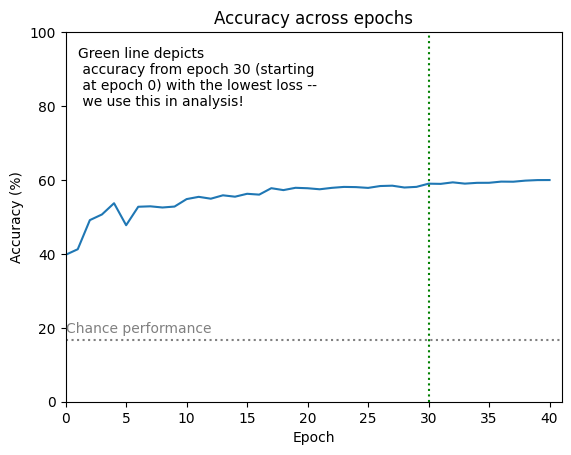

In [21]:
if fitNew == True:
  bestEpoch = lossCheck[1]
  performanceSummary = performanceSummary.iloc[:,0:t+1] #in case early stopping happens
  epAcc = (100*(performanceSummary.sum() / len(test_dataloader.dataset)))
  bestPerformance = epAcc[bestEpoch]

  #plot accuracy across epochs and label accuracy from interation with lowest validation loss
  fig, ax = plt.subplots()
  ax.plot(range(t+1), epAcc)
  plt.xlim(0, t+1)
  plt.ylim(0, 100)
  ax.axvline(x = bestEpoch, linestyle = "dotted", color = "green")
  ax.axhline(y = (100/6), linestyle = "dotted", color = "grey")
  ax.text(x = 1, y = 80, s = f"Green line depicts \n accuracy from epoch {bestEpoch} (starting \n at epoch 0) with the lowest loss -- \n we use this in analysis!")
  ax.text(x=0, y = (100/6) + 2, s = "Chance performance", color = "grey")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.title("Accuracy across epochs")

  #view graph and accuracy values across epochs
  fig.show()
  print(epAcc)

  #Download plot
  fig.savefig("acrossEpochPlot_" + analysisString + "_Decay.png")
  files.download("acrossEpochPlot_" + analysisString + "_Decay.png")
else:
  print("Toggle to newly fit models has been turned off")

## View accuracy from epoch with lowest loss

In [22]:
if fitNew == True:
  #load in best weights
  bestWeights = torch.load("checkpoint.pth")
  model.load_state_dict(bestWeights)

  #check of prediction accuracy for model
  trialLevelAcc = pd.DataFrame(index=range(len(test_dataloader.dataset)), columns = range(1))
  trialLevelPredictions = pd.DataFrame(index=range(len(test_dataloader.dataset)), columns = range(1))
  trialLevelLogits = pd.DataFrame(index=range(len(test_dataloader.dataset)), columns = range(6))
  test_model(test_dataloader, model, loss_fn, trialLevelAcc,
           trialLevelPredictions, trialLevelLogits, mode = "accuracy")


else:
  print("Toggle to newly fit models has been turned off")

Accuracy: 58.995482% 



## Download relevant model performance metrics as .csv files through Google Drive
This is done in multiple code sections because the resulting files are quite large, and some may not  download if all are run in one section.

In [26]:
if fitNew == True:
  #trial-level accuracy across epochs
  performanceSummary.to_csv("acrossEpochAccuracy_" + analysisString + "_Decay.csv")
  files.download("acrossEpochAccuracy_" + analysisString + "_Decay.csv")

else:
  print("Toggle to newly fit models has been turned off")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [25]:
if fitNew == True:

  #trial-level accuracy from best epoch
  trialLevelAcc.to_csv("trialLevelAccuracy_" + analysisString + "_Decay.csv")
  files.download("trialLevelAccuracy_" + analysisString + "_Decay.csv")

  #model weights
  torch.save(bestWeights, "model_state_" + analysisString + "_Decay.pth") #.pth file is type used for storing parameter weights
  files.download("model_state_" + analysisString + "_Decay.pth")

else:
  print("Toggle to newly fit models has been turned off")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [24]:
if fitNew == True:
  #trial-level predictions from best epoch
  trialLevelPredictions.to_csv("trialLevelPredictions_" + analysisString + "_Decay.csv")
  files.download("trialLevelPredictions_" + analysisString + "_Decay.csv")

  #trial-level logits (CNN output values) from best epoch
  trialLevelLogits.to_csv("trialLevelOutputs_" + analysisString + "_Decay.csv")
  files.download("trialLevelOutputs_" + analysisString + "_Decay.csv")

else:
  print("Toggle to newly fit models has been turned off")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **--------Section 3: Direct replication of reported results -------**

This section only runs if `fitNew` is set to False. **Prior to running this section**, make sure to load the corresponding model weights into the Colab environment.

## View exact accuracy of the model from the corresponding results section
If you would like to see the performance of the model that produced the classifcation accuracy reported in the corresponding results section, run the code below. **Prior to running this code,** upload the corresponding `.pth` file to the Colab environment.

In [ ]:
if fitNew == False:
  if replicateAnalysis == "massaTarget":
    weightsName = "model_state_MassaTargLoc_Decay.pth"

  elif replicateAnalysis == "grubbLiTarget":
    weightsName = "model_state_GrubbLiTargLoc_Decay.pth"

  elif replicateAnalysis == "massaDistractor":
    weightsName = "model_state_MassaDistLoc_Decay.pth"

  elif replicateAnalysis == "grubbLiDistractor":
    weightsName = "model_state_GrubbLiDistLoc_Decay.pth"

  #load in weights
  modelWeights = torch.load(weightsName)
  model.load_state_dict(modelWeights)

  #check accuracy
  performanceReplication = pd.DataFrame(index=range(len(test_dataloader.dataset)), columns = range(1))
  predictionsReplication = pd.DataFrame(index=range(len(test_dataloader.dataset)), columns = range(1))
  logitsReplication = pd.DataFrame(index=range(len(test_dataloader.dataset)), columns = range(6))
  test_model(test_dataloader, model, loss_fn, performanceReplication,
            predictionsReplication, logitsReplication, mode = "accuracy")
else:
  print("Toggle to directly replicate results has been turned off")

# **--------Section 4: SHAP analysis -------**

This section runs whether you are trying to newly fit the models to the data (`fitNew = True`) or just produce the exact results reported in the paper (`fitNew = False`). We have made the SHAP analysis its own section as it takes a substantial amount of time + processing to run.

## Calculate SHAP values for each trial of validation set

In [27]:
trialLevelSHAP = pd.DataFrame(index=range(len(test_dataloader.dataset)), columns = range(len(test_dataloader.dataset[0][0][0])))
print(trialLevelSHAP.shape)

shapBatch = test_dataloader.dataset[0:100] #first 100 trials used for explanation model
explainer = shap.DeepExplainer(model, shapBatch[0])

loopDur = len(test_dataloader.dataset)
for s in range(loopDur):

  #calculate SHAP values relative to explainer set
  shap_values = explainer.shap_values(test_dataloader.dataset[s:s+1][0])

  #compute global feature importance by taking absolute value
  abs_shap_values = np.abs(shap_values)

  #average across classes and features to get one global feature importance value per sample
  SHAP = abs_shap_values.mean(axis=(0,1,3))

  #save trial-level SHAP values to initialized dataframe
  trialLevelSHAP.iloc[s,:] = SHAP
  if s % 100 ==0:
    print(s)

print("Done!")

(7526, 600)


/usr/local/lib/python3.12/dist-packages/shap/explainers/_deep/deep_pytorch.py:255: UserWarning: unrecognized nn.Module: Flatten
  warnings.warn(f"unrecognized nn.Module: {module_type}")


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
Done!


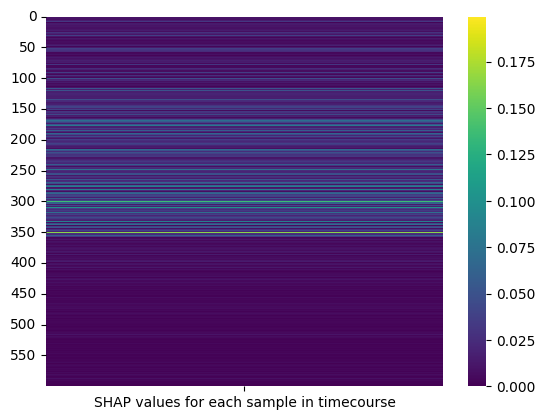

In [28]:
#Graphing heatmap of results for last trial as a quick check
df = pd.DataFrame({"SHAP values for each sample in timecourse": abs_shap_values.mean(axis=(0,1,3))},
                  index=range(len(shap_values[0][0])))
g = sns.heatmap(df, fmt="g", cmap='viridis')
g.set_yticks(range(0,600,50))
g.set_yticklabels(range(0,600,50))
plt.show()

## Download SHAP values as .csv file

In [29]:
trialLevelSHAP = pd.DataFrame(trialLevelSHAP)
trialLevelSHAP.to_csv("shapValues_" + analysisString + "_Decay.csv")
files.download("shapValues_" + analysisString + "_Decay.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>